<table>
<tr>
    <td width=10%><img src="../img/logo_lri.jpg"></td>
    <td width=30%><img src="../img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">Challenge - Survival Analysis </a></center>
<center><font size="5">Gerspacher Thomas</font></center>
<br/>

---

In [1]:
import sys
sys.path.append('../')

In [2]:
import lib.nb_settings as nbs

packages = ['numpy', 'matplotlib', 'pandas' , 'sklearn']
nbs.check_packages(packages)

numpy               :	1.14.4
matplotlib          :	2.2.2
pandas              :	0.23.0
sklearn             :	0.19.1


In [3]:
%matplotlib inline

<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#Mimic"> Basic operations on MIMIC-III dataset </a><br/>
&emsp;&emsp;&emsp; II) <a href="#Estimation"> Estimation </a><br/>
&emsp;&emsp;&emsp;&emsp;&emsp; 1) <a href="#KM"> Kaplan-Meier Estimator </a><br/>
&emsp;&emsp;&emsp;&emsp;&emsp; 2) <a href="#NA"> Nelson-Aalen Estimator </a><br/>
&emsp;&emsp;&emsp;&emsp;&emsp; 3) <a href="#KM-NA"> Relationship between estimators </a><br/>
&emsp;&emsp;&emsp; III) <a href="#Regression"> Survival Regression </a><br/>
&emsp;&emsp;&emsp;&emsp;&emsp; 1) <a href="#Cox"> Cox Regression </a><br/>

## <a id="Mimic"> I) Basic operations on MIMIC-III dataset </a>  

MIMIC-III is an openly available dataset developed by the MIT Lab for Computational Physiology, comprising deidentified health data associated with ~30,000 critical care patients. It includes demographics, vital signs, laboratory tests, medications, and more.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

features = pd.read_csv('../data/mimic_auto/mimic_feat.name', header=None).values.flatten()
mimic = pd.read_csv('../data/mimic_auto/mimic.data', names=features, sep=' ')
mimic = mimic.dropna(axis=0)

mimic.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,V81,V83,V84,V85,V86,V87,V88,V90,V91,ICU
11,357,174486,2197-12-06_07:13:00,2198-01-03_14:00:00,Private,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0,0,0,0,MICU
12,359,144265,2176-06-30_03:00:00,2176-07-03_15:12:00,Self_Pay,VIET,BUDDHIST,MARRIED,UNKNOWN/NOT_SPECIFIED,M,...,0,0,0,0,0,0,0,0,0,CSRU
24,43,146828,2186-10-01_23:15:00,2186-10-11_18:00:00,Private,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0,0,0,0,TSICU
25,44,181750,2192-11-19_18:14:00,2192-11-27_14:35:00,Medicare,ENGL,CATHOLIC,MARRIED,UNKNOWN/NOT_SPECIFIED,M,...,0,0,0,0,0,0,0,0,0,CSRU
33,64,172056,2143-03-03_09:25:00,2143-03-18_13:01:00,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN_AMERICAN,F,...,0,0,0,0,0,0,0,0,0,MICU


In [5]:
from sklearn.model_selection import train_test_split

mimic_train, mimic_test = train_test_split(mimic, train_size=0.8, test_size=0.2)
time_train, time_test = mimic_train['LOS'], mimic_test['LOS']
event_train, event_test = mimic_train['DIED'], mimic_test['DIED']

## <a id="Estimation"> II) Estimation </a>

### <a id="KM"> II. 1) Kaplan-Meier Estimator

The goal is to use the Kaplan-Meier estimator to estimate the survival function of the patients.

<div class="alert alert-block alert-warning">
    <b>Reminder:</b> 
    The Kaplan-Meier estimator is an non parametric estimator of the **survival function** obtained by the maximum likelihood estimation.
    <br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; It is defined by : 
</div>


\begin{equation}
\hat{S}(t) = \prod_{i; t_i <t} \dfrac{n_i - d_i}{n_i}
\end{equation}

>with $n_i$ the number of individuals who has not experienced the event at time $t_i$

>and $d_i$ the number of individuals that experience the event at time $t_i$

<div class="alert alert-block alert-success">
    <b>Question:</b> 
    Define the Kaplan-Meier estimator.
</div>

In [6]:
def km_estimate(t, e):
    assert(len(t) == len(e))
    time_event = pd.Series(data = e.values, index=t.values).sort_index()

    survival = pd.Series(index=np.unique(t))
    # Assumption: At time 0, all patients are alive.
    survival[0.0] = 1.0
    survival = survival.sort_index()
    
    d_i = 0
    n_i = len(time_event)
    estimate = 1.0

    for time in time_event.index:
        d_i = time_event[time].sum()
        estimate *= (n_i - d_i) / n_i
        survival[time] = estimate
        n_i = len(time_event.loc[time_event.index > time]) - d_i
    return survival

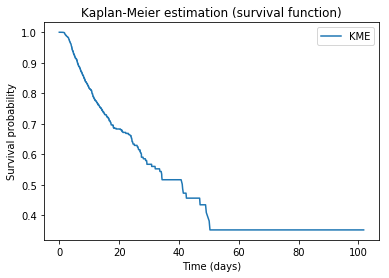

In [59]:
kme = km_estimate(time_train, event_train)

fig, ax = plt.subplots()
kme.plot(ax=ax)
plt.legend(['KME'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
ax.set_title('Kaplan-Meier estimation (survival function)');

<div class="alert alert-block alert-info">
    <b>Solution:</b> 
    Using lifelines library.
</div>

In [8]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(time_train, event_train)
kme_lifelines = kmf.survival_function_

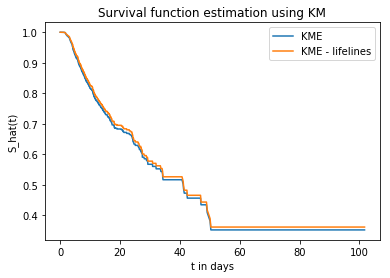

In [9]:
fig, ax = plt.subplots()
kme.plot(ax=ax)
kme_lifelines.plot(ax=ax)
plt.legend(['KME', 'KME - lifelines'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
ax.set_title('Survival function estimation using KM');

### <a id="NA"> II. 2) Nelson-Aalen Estimator
    
The goal is to use the Kaplan-Meier estimator to estimate the cumulative hazard function of the patients.

<div class="alert alert-block alert-warning">
    <b>Reminder:</b> 
    The Nelson-Aalen estimator is a non-parametric estimator of the **cumulative hazard** function obtained by the maximum likelihood estimation.
    <br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; It is defined by : 
</div>

\begin{equation}
    \hat{H}(t) = \sum_{i; t_i<t} \dfrac{d_i}{n_i}
\end{equation}

>with $n_i$ the number of individuals who has not experienced the event at time $t_i$

>and $d_i$ the number of individuals that experience the event at time $t_i$

<div class="alert alert-block alert-success">
    <b>Question:</b> 
    Define the Nelson-Aalen estimator.
</div>

In [10]:
def na_estimate(t, e):
    assert(len(t) == len(e))
    time_event = pd.Series(data = e.values, index=t.values).sort_index()

    cumhazard = pd.Series(index=np.unique(t))
    # Assumption: At time 0, all patients are alive.
    cumhazard[0.0] = 0.0
    cumhazard = cumhazard.sort_index()
    
    d_i = 0
    n_i = len(time_event)
    estimate = 0.0

    for time in time_event.index:
        d_i = time_event[time].sum()
        estimate += d_i / n_i
        cumhazard[time] = estimate
        n_i = len(time_event.loc[time_event.index > time]) - d_i
    return cumhazard

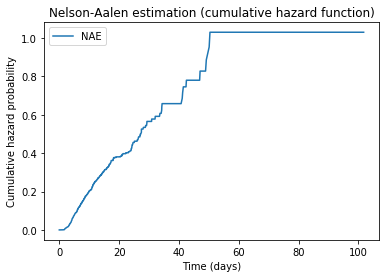

In [61]:
nae = na_estimate(time_train, event_train)

fig, ax = plt.subplots()
nae.plot(ax=ax)
plt.legend(['NAE'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Cumulative hazard probability')
ax.set_title('Nelson-Aalen estimation (cumulative hazard function)');

<div class="alert alert-block alert-info">
    <b>Solution:</b> 
    Using lifelines library.
</div>

In [12]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(time_train, event_train)
nae_lifelines = naf.cumulative_hazard_

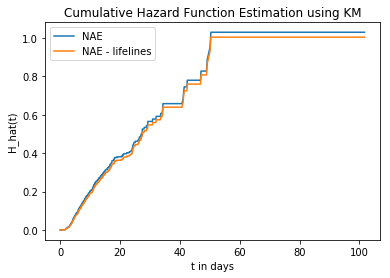

In [13]:
fig, ax = plt.subplots()
nae.plot(ax=ax)
nae_lifelines.plot(ax=ax)
ax.set_xlabel('t in days')
ax.set_ylabel('H_hat(t)')
ax.set_title('Cumulative Hazard Function Estimation using KM')
plt.legend(['NAE', 'NAE - lifelines']);

### <a id="KM-NA"> II. 3) Relations between Survival and Cumulative Hazard Function
    
<div class="alert alert-block alert-warning">
    <b>Reminder:</b> 
    Survival function and cumulative hazard function are linked through simple relations.
    <br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
</div>

\begin{align}
    H(t) & = -\ln(S(t)) \\
    S(t) & = e^{-H(t)}
\end{align}

<div class="alert alert-block alert-success">
    <b>Question:</b> 
    Define the relations between cumulative hazard and survival.
</div>

In [14]:
def survival_to_cumhazard(s):
    return -np.log(s)

def cumhazard_to_survival(h):
    return np.exp(-h)

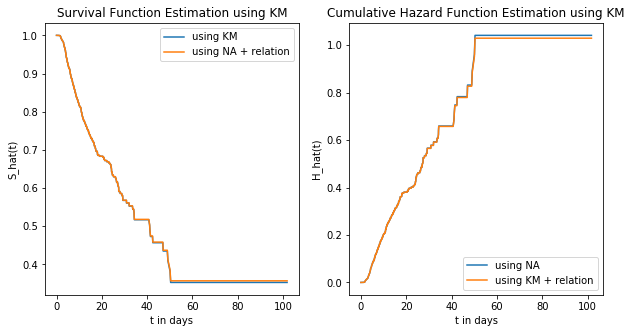

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

kme.plot(ax=ax[0])
cumhazard_to_survival(nae).plot(ax=ax[0])
ax[0].set_xlabel('t in days')
ax[0].set_ylabel('S_hat(t)')
ax[0].set_title('Survival Function Estimation using KM')
ax[0].legend(['using KM', 'using NA + relation'])

survival_to_cumhazard(kme).plot(ax=ax[1])
nae.plot(ax=ax[1])
ax[1].set_xlabel('t in days')
ax[1].set_ylabel('H_hat(t)')
ax[1].set_title('Cumulative Hazard Function Estimation using KM')
ax[1].legend(['using NA', 'using KM + relation']);

### <a id="Comparison"> II. 4) Compare survival functions

Let us now compare survival functions using statistical tests.

We will use the same dataset but it will be divided into two parts: males and females.

Let us first look at the the two survival functions on a simple plot.

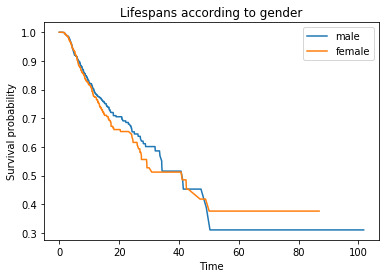

In [56]:
males = (mimic['GENDER'] == 'M')

kme_males = km_estimate(time_train[males], event_train[males])
kme_females = km_estimate(time_train[~males], event_train[~males])

fig, ax = plt.subplots()
kme_males.plot(ax=ax)
kme_females.plot(ax=ax)
plt.legend(['male', 'female'])
ax.set_xlabel('Time')
ax.set_ylabel('Survival probability')
ax.set_title('Lifespans according to gender');

We now want to know if both survival functions follows the same survival distribution. 

A widely statistic to perform this task is the log-rank test.

### <a id="logrank"> II. 4. a) Log-rank test

<div class="alert alert-block alert-warning">
    <b>Reminder:</b> 
    Log rank test is a non parametric test with the following hypothesis: <br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;H0 : S1 and S2 follows the same survival distribution. <br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;H1 : S1 and S2 don't follow the same survival distribution. <br>
</div>

In [57]:
from lifelines.statistics import logrank_test

results = logrank_test(time_train[males], time_train[~males], event_train[males], event_train[~males], alpha=.99)

results.print_summary()


null_distribution=chi squared, alpha=0.99, df=1, t_0=-1

test_statistic      p   
        0.9006 0.3426
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


The p-value indicates that there is a difference in the probability of death according to gender.

#### Survival function according to ICU

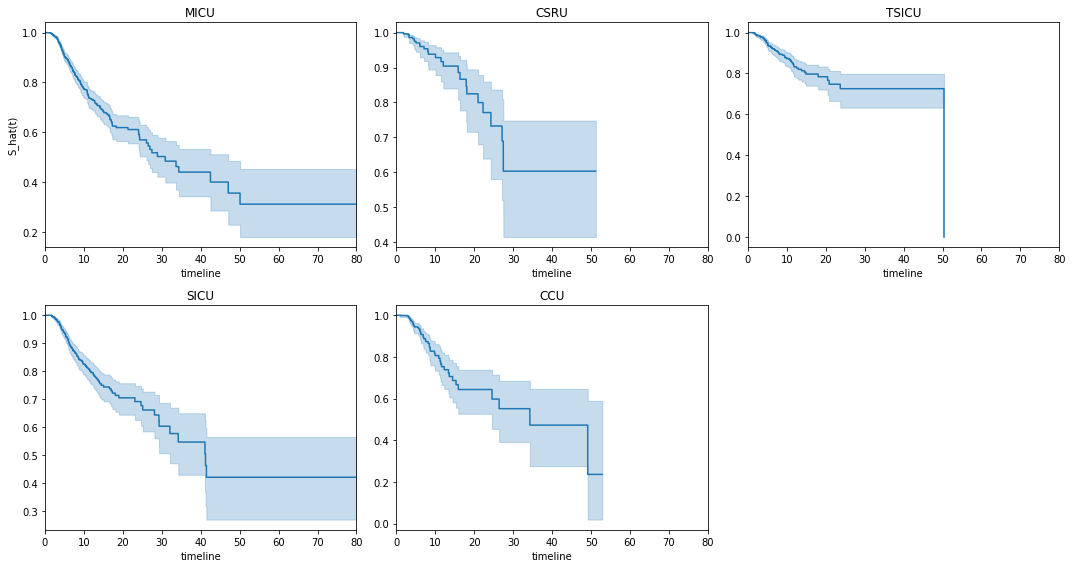

In [20]:
icus = mimic['ICU'].unique()

fig = plt.figure(figsize=(15, 8))
for i, icu in enumerate(icus):
    ax = plt.subplot(2, 3, i+1)
    ix = mimic['ICU'] == icu
    kmf.fit(time_train[ix], event_train[ix], label=icu)
    kmf.plot(ax=ax, legend=False)
    plt.title(icu)
    plt.xlim(0, 80)
    if i==0:
        plt.ylabel('S_hat(t)')
plt.tight_layout()

#### I.1.3 Hazard Function



In order to get the hazard function, we need to derive the cumulative hazard function but
the derivation involves a kernel smoother (to smooth out the differences of the cumulative hazard curve), and this requires us to specify a bandwidth parameter that controls the amount of smoothing.

In [21]:
bw = 10

In [22]:
hazard_estimate = naf.smoothed_hazard_(bw)

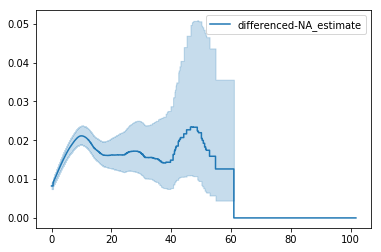

In [23]:
naf.plot_hazard(bandwidth = bw)

## <a id="Regression"> III) Survival Regression </a>

### <a id="Cox"> 1) Cox Regression
    
The goal of survival regression is to estimate the hazard function using data X, i.e. $\lambda (t/X)$

\begin{equation}
    \lambda (t/X) = b_0(t) \exp{(\sum_i^d x_i \beta_i)}
\end{equation}


Cox Regression cannot handle categorical data at the moment, so we remove them from the dataset.

In [498]:
stamp = pd.concat([mimic[mimic.columns[0:57]], mimic['ICU']], axis=1)

stamp = stamp.dropna(axis=0)
stamp = stamp.drop(stamp.columns[stamp.dtypes == 'object'], axis=1)

In [43]:
from lifelines import CoxPHFitter

mimic_train_processed = pd.concat([mimic_train[mimic_train.columns[4:57]], mimic_train['ICU']], axis=1)
mimic_train_processed = mimic_train_processed[mimic_train_processed.dtypes[mimic_train_processed.dtypes != 'object'].index.values]
mimic_test_processed = pd.concat([mimic_test[mimic_test.columns[4:57]], mimic_test['ICU']], axis=1)
mimic_test_processed = mimic_test_processed[mimic_test_processed.dtypes[mimic_test_processed.dtypes != 'object'].index.values]

cph = CoxPHFitter()
cph.fit(mimic_train_processed, duration_col='LOS', event_col='DIED', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 1.03408, step_size = 0.95000, ll = -3827.27709, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.28193, step_size = 0.95000, ll = -3717.71240, seconds_since_start = 0.4
Iteration 3: norm_delta = 0.02886, step_size = 0.95000, ll = -3713.97369, seconds_since_start = 0.6
Iteration 4: norm_delta = 0.00163, step_size = 0.95000, ll = -3713.92739, seconds_since_start = 0.8
Iteration 5: norm_delta = 0.00008, step_size = 0.95000, ll = -3713.92722, seconds_since_start = 1.0
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -3713.92722, seconds_since_start = 1.2
Convergence completed after 6 iterations.
n=7833, number of events=527

                       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
AGE                 -0.0011     0.9989    0.0005 -2.1140 0.0345     -0.0020     -0.0001    *
HR_MIN_DAY1         -0.0085     0.9915    0.0069 -1.2359 0.2165     -0.0220      0.0050     
HR_MAX_DAY1         -0.0004     0.9996    0.0047 

### Coefficient visualization

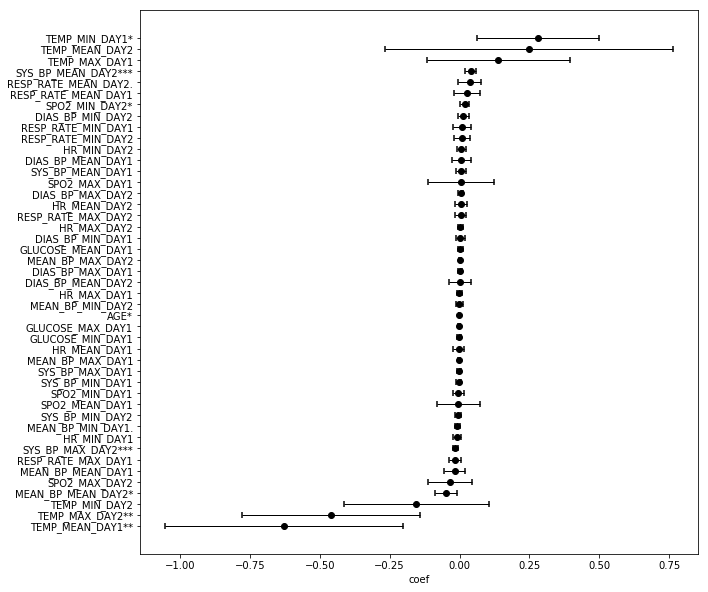

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
cph.plot(ax=ax)

In [46]:
survival_pred = cph.predict_survival_function(mimic_train_processed.drop(['DIED', 'LOS'], axis=1))

In [47]:
survival_pred.tail()

,26125,17626,16265,5131,17627,21157,15695,25543,21078,14340,...,5830,16664,1834,15698,18088,17181,19399,7061,15867,2658
event_at,,,,,,,,,,,,,,,,,,,,,
61.9263,0.192771,0.571685,0.40209,0.48217,0.479219,0.094279,0.555897,0.714138,0.196441,0.226293,...,0.585507,0.204517,0.648241,0.427885,0.472948,0.052136,0.184747,0.48509,0.371925,0.089902
79.1090,0.192771,0.571685,0.40209,0.48217,0.479219,0.094279,0.555897,0.714138,0.196441,0.226293,...,0.585507,0.204517,0.648241,0.427885,0.472948,0.052136,0.184747,0.48509,0.371925,0.089902
81.1664,0.192771,0.571685,0.40209,0.48217,0.479219,0.094279,0.555897,0.714138,0.196441,0.226293,...,0.585507,0.204517,0.648241,0.427885,0.472948,0.052136,0.184747,0.48509,0.371925,0.089902
86.8484,0.192771,0.571685,0.40209,0.48217,0.479219,0.094279,0.555897,0.714138,0.196441,0.226293,...,0.585507,0.204517,0.648241,0.427885,0.472948,0.052136,0.184747,0.48509,0.371925,0.089902
101.7390,0.192771,0.571685,0.40209,0.48217,0.479219,0.094279,0.555897,0.714138,0.196441,0.226293,...,0.585507,0.204517,0.648241,0.427885,0.472948,0.052136,0.184747,0.48509,0.371925,0.089902


In [49]:
cum_hazard_pred = cph.predict_cumulative_hazard(mimic_train_processed.drop(['DIED', 'LOS'], axis=1))

In [50]:
cum_hazard_pred.tail()

,26125,17626,16265,5131,17627,21157,15695,25543,21078,14340,...,5830,16664,1834,15698,18088,17181,19399,7061,15867,2658
event_at,,,,,,,,,,,,,,,,,,,,,
61.9263,1.64625,0.559168,0.91108,0.729459,0.735597,2.361498,0.587173,0.336679,1.627394,1.485926,...,0.535278,1.587103,0.433492,0.8489,0.748769,2.953901,1.688767,0.72342,0.989062,2.409038
79.1090,1.64625,0.559168,0.91108,0.729459,0.735597,2.361498,0.587173,0.336679,1.627394,1.485926,...,0.535278,1.587103,0.433492,0.8489,0.748769,2.953901,1.688767,0.72342,0.989062,2.409038
81.1664,1.64625,0.559168,0.91108,0.729459,0.735597,2.361498,0.587173,0.336679,1.627394,1.485926,...,0.535278,1.587103,0.433492,0.8489,0.748769,2.953901,1.688767,0.72342,0.989062,2.409038
86.8484,1.64625,0.559168,0.91108,0.729459,0.735597,2.361498,0.587173,0.336679,1.627394,1.485926,...,0.535278,1.587103,0.433492,0.8489,0.748769,2.953901,1.688767,0.72342,0.989062,2.409038
101.7390,1.64625,0.559168,0.91108,0.729459,0.735597,2.361498,0.587173,0.336679,1.627394,1.485926,...,0.535278,1.587103,0.433492,0.8489,0.748769,2.953901,1.688767,0.72342,0.989062,2.409038


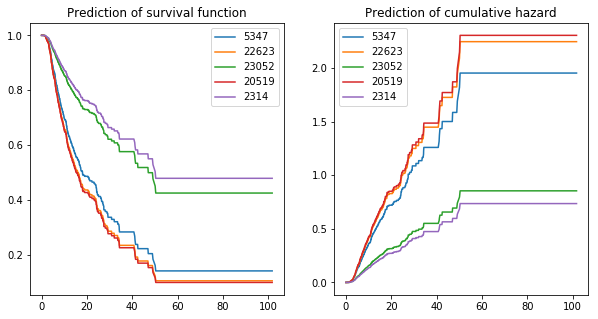

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(5):
    rand = np.random.randint(len(survival_pred.columns))
    ax[0].plot(survival_pred[survival_pred.columns[rand]], label=survival_pred.columns[rand])
    ax[1].plot(cum_hazard_pred[cum_hazard_pred.columns[rand]], label=cum_hazard_pred.columns[rand])

ax[0].set_title('Prediction of survival function')
ax[0].legend()
ax[1].set_title('Prediction of cumulative hazard')
ax[1].legend()